## Example Queries for Numerator

In this tutorial notebook, we utilize the Python API to query Kellogg's Numerator dataset hosted on Redivis. The API uses a web browser to authenticate Kellogg users via SSO, so no additional steps are required beyond installing the ```redivis``` Python module via pip. We also choose to view/manipulate the downloaded data using Pandas and Matplotlib, though there are many other options available as well (e.g., polars, seaborn, ggplot, dplyr, etc.)

Structured Query Language (SQL) is a nearly universal language for querying relational databases. Redivis uses Google's BigQuery as a backend for its cloud database design. These queries may need to be modified slightly to run on other databases as they use functions designed and optimized for BigQuery instead of AWS/Athena, for example.

In [1]:
import redivis
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
%matplotlib inline

## Example 1: Average daily price of a carton of eggs

In [4]:
with open("redivis/egg_prices.sql", "r") as f:
    egg_prices_sql = f.read()

display(Markdown(f"```sql\n{egg_prices_sql}\n```"))

```sql
WITH item_batch AS (
  SELECT 
    item_id, 
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_item_table`
  GROUP BY item_id
), trans_batch AS (
  SELECT transaction_date, MAX(DATE(batch_date)) as latest_batch_date
  FROM `standard_nmr_feed_fact_table`
  GROUP BY transaction_date
) 
SELECT 
  DATE(t.transaction_date) AS transaction_date, 
  AVG(t.item_unit_price) as avg_price,
  STDDEV(t.item_unit_price) as std_price,
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(24)] as lq_price,
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(49)] AS median_price,
  APPROX_QUANTILES(t.item_unit_price, 100)[OFFSET(74)] AS uq_price
FROM `standard_nmr_feed_fact_table` AS t
JOIN trans_batch AS tb
ON t.transaction_date = tb.transaction_date
AND DATE(t.batch_date) = tb.latest_batch_date
JOIN `standard_nmr_feed_item_table` i
ON i.item_id = t.item_id
JOIN item_batch ib
ON i.item_id = ib.item_id
AND DATE(i.batch_date) = ib.latest_batch_date  
WHERE i.category_id = 'isc_gro_dai_egg_cage_free'
AND i.item_description like '%12%'
GROUP BY transaction_date

```

#### Step 1: querying the fact table

The ```standard_nmr_feed_item_table```,  or simply, the item table, contains information on every individual item purchased in the Numerator dataset. The data are categorized using a hierarchical index.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Level</th>
      <th>Description</th>
      <th>ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Sector</td>
      <td>Grocery</td>
      <td>isc_grocery</td>
    </tr>
    <tr>
      <td>Department</td>
      <td>Dairy</td>
      <td>isc_gro_dairy</td>
    </tr>
    <tr>
      <td>Major Category</td>
      <td>Eggs</td>
      <td>isc_gro_dai_eggs</td>
    </tr>
    <tr>
      <td>Category</td>
      <td>Cage Free Eggs</td>
      <td>isc_gro_dai_egg_cage_free</td>
    </tr>
    <tr>
      <td>Sub-category</td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>

We expect there to be quite a bit of variance in the prices of eggs based on the product type. In this example, we chose to only select cage-free eggs, however, there are many other categories that fall under the major category of eggs (i.e., hard-boiled, free-range, egg substitute, etc.). Including the major category in the filter along with the category is redundant, but we include it in this example in case the user wishes to look at a different category.

It's also important we are comparing prices of products with the same quantity of eggs. Unfortunately, obtaining the carton-size is not as trivial as the step before. Because this is just an example, we'll make a rough attempt at selecting out cartons with a dozen eggs by doing a grep search on the number "12". Naturally, this might miss product descriptions using abbreviations like "DZ" for dozen instead of "12ct" or may include descriptions with product IDs instead of counts, but we can adjust for those incorrect values by aggregating our data in a smart manner below.

#### Step 2: querying the fact table

All of the transactions are located in the facts table. In this case, a singular transaction is called a "basket" that has one row for every unique item included in the transaction.

To get all the transactions related to eggs, we join the previous query with the fact table on the item ID. We also join on batch date to ensure that we retrieve the correct version of the dataset. If we want to include data from 2018-2024, we have to include data from two different batches: (1) batch_date='2024-05-13' for all data from 2018-01-01 through 2023-12-31 and (2)batch_date='2024-10-21' for 2024-01-01 through 2024-09-30.

#### Step 3: aggregating the data

Our final step is to get the average daily prices. We show this in a couple different ways. We first group by transaction date and then take the mean and standard deviation of all prices. However, as we said before, we did not attempt to clean up our item list, so we naturally expect there to be outlier prices. A better measurement of the typical value and variance might instead be the median and interquartile range. The advantage of computing mean/STD over median/IQR is that it does not require the data to be sorted. It would be impractical to compute the exact median for a data set containing billions of records such as this, so luckily BigQuery has a function called APPROX_QUANTILES to provide an approximate these values without needing to sort the data.

### Downloading the data

Since our query only references table names, we have to invoke the organization (Kellogg) and dataset (Numerator) in the Python API prior to running the query. We'll run the query and convert it to a pandas dataframe. From there, we'll save it locally as a parquet file.

In [5]:
df = redivis.organization('kellogg').dataset('numerator')\
            .query(egg_prices_sql).to_pandas_dataframe()
df.to_parquet('egg_prices.parquet',index=False)
df.head()

Please authenticate with your Redivis account. Opening browser to:
https://redivis.com/oauth/authorize?requestedLogin=eyJpZCI6MTAxNTcsImVtYWlsIjoidHJhY2kuam9obnNvbi4zMkBnbWFpbC5jb20iLCJhdXRoZW50aWNhdGlvblR5cGUiOiJnb29nbGUiLCJJZGVudGl0eVByb3ZpZGVySWQiOm51bGwsIklkZW50aXR5UHJvdmlkZXIiOm51bGx9&user_code=fd2027cacc43de3fbfdc58acce417028


  0%|          | 0/2465 [00:00<?, ?it/s]

,transaction_date,avg_price,std_price,lq_price,median_price,uq_price
0,2023-07-06,3.23138,1.157503,2.59,2.79,3.69
1,2021-02-02,3.226848,0.928881,2.48,2.99,3.79
2,2022-04-09,3.01706,0.911014,2.48,2.77,3.49
3,2021-05-30,3.051657,0.909358,2.48,2.82,3.49
4,2019-06-26,3.199543,0.933504,2.48,2.99,3.79


### Plotting the data

We'll work off of the data we downloaded from disk. Before we plot, we want to make some modifications. If we want to create a line plot, we need to sort by transaction date so the lines are drawn between consecutive dates. We chose to aggregate the data at the day level; however, this looks very noisy. To make the plot look a little cleaner, we'll instead plot the data smoothed over a 7-day average. We'll also overplot the IQR as a lightly-shaded region to show the variance in prices.

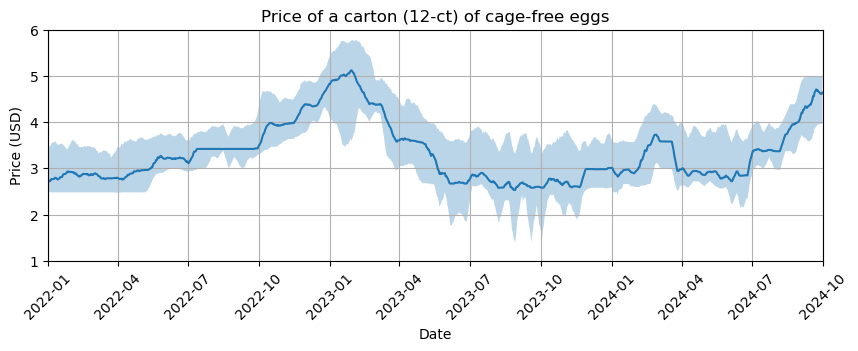

In [6]:
df = pd.read_parquet('egg_prices.parquet')\
        .sort_values(by='transaction_date')\
        .reset_index(drop=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['median_price_7d'] = df['median_price'].rolling(7).mean()
df['lq_price_7d'] = df['lq_price'].rolling(7).mean()
df['uq_price_7d'] = df['uq_price'].rolling(7).mean()
df = df[df['transaction_date'].dt.year >= 2022].reindex()

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['transaction_date'],df['median_price_7d'])
ax.fill_between(df['transaction_date'],df['lq_price_7d'],df['uq_price_7d'],alpha=0.3)
ax.set_xlim(pd.to_datetime('2022-01-01'),pd.to_datetime('2024-10-01'))
ax.set_ylim(1,6)
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('Price of a carton (12-ct) of cage-free eggs')
ax.tick_params(axis='x', rotation=45)
plt.savefig('egg_prices.png')
plt.show()

## Example 2: Social media influencer products

In [7]:
with open("redivis/collagen_demographics.sql", "r") as f:
    collagen_sql = f.read()

display(Markdown(f"```sql\n{collagen_sql}\n```"))

```sql
WITH item_batch AS (
  SELECT 
    item_id, 
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_item_table`
  GROUP BY item_id
), trans_batch AS (
  SELECT transaction_date, MAX(DATE(batch_date)) as latest_batch_date
  FROM `standard_nmr_feed_fact_table`
  GROUP BY transaction_date
), people_batch AS (
  SELECT 
    user_id, 
    MAX(DATE(batch_date)) AS latest_batch_date
  FROM `standard_nmr_feed_people_table`
  GROUP BY user_id
)
SELECT 
  t.transaction_date, 
  p.gender_app_user, 
  p.age_bucket, 
  SUM(t.item_quantity) as units_sold
FROM `standard_nmr_feed_item_table` i
JOIN `standard_nmr_feed_fact_table` t
ON i.item_id = t.item_id
JOIN `standard_nmr_feed_people_table` p
ON p.user_id = t.user_id
JOIN item_batch ib
ON i.item_id = ib.item_id
AND DATE(i.batch_date) = ib.latest_batch_date
JOIN trans_batch tb 
ON t.transaction_date = tb.transaction_date
AND DATE(t.batch_date) = tb.latest_batch_date
JOIN people_batch pb
ON p.user_id = pb.user_id
AND DATE(p.batch_date) = pb.latest_batch_date
WHERE i.category_id = 'isc_hea_vit_min_collagen'
GROUP BY 1, 2, 3
```

### Download the data

In [8]:
df = redivis.organization('kellogg').dataset('numerator')\
            .query(collagen_sql).to_pandas_dataframe()
df.to_parquet('collagen_demographics.parquet',index=False)
df.head()

  0%|          | 0/40711 [00:00<?, ?it/s]

,transaction_date,gender_app_user,age_bucket,units_sold
0,2023-04-10,Male,18-20,8.0
1,2024-06-02,Female,18-20,2.0
2,2021-11-06,Female,18-20,1.0
3,2024-05-16,Female,18-20,1.0
4,2022-11-30,Female,18-20,2.0


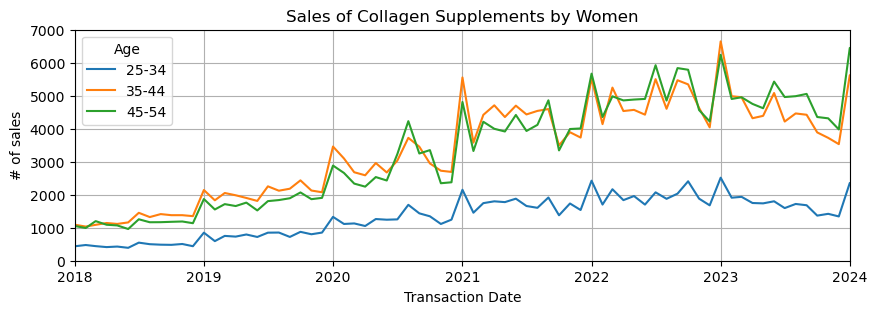

In [26]:
df = pd.read_parquet('collagen_demographics.parquet')
df['month'] = df['transaction_date'].apply(lambda x: pd.Period(x,freq='M').start_time)

df = df[df['gender_app_user'].eq('Female') &
        df['age_bucket'].isin(['25-34','35-44','45-54'])].dropna()\
        .groupby(['month','age_bucket'])\
        .agg({'units_sold':'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(10,3))

age_buckets = df['age_bucket'].unique()
for a in age_buckets:
    ax.plot(df.loc[df['age_bucket'].eq(a),'month'],
            df.loc[df['age_bucket'].eq(a),'units_sold'],
            label=a)
ax.legend(title='Age')
ax.set_xlim(pd.to_datetime('2018-01-01'),pd.to_datetime('2024-01-01'))
ax.set_ylim(0,7000)
ax.set_xlabel('Transaction Date')
ax.set_ylabel('# of sales')
ax.set_title('Sales of Collagen Supplements by Women')
ax.grid()
plt.savefig('collagen_demographics.png')
plt.show()

In [29]:
with open("redivis/polygon.sql", "r") as f:
    polygon_sql = f.read()

display(Markdown(f"```sql\n{polygon_sql}\n```"))

```sql
  SELECT 
    c.geometry AS county_borders, 
    c.name as county_name, 
    s.name as state_name
  FROM `demo.us_political_boundaries.us_counties` c
  JOIN `demo.us_political_boundaries.us_states` s
  ON s.state = c.state
  WHERE (
    (s.name = 'Illinois' and c.name = 'St. Clair') OR
    (s.name = 'Missouri' and c.name = 'St. Louis'))
  AND c.lsad = 'County'
```

In [38]:
gdf = redivis.query(polygon_sql).to_geopandas_dataframe()

  0%|          | 0/2 [00:00<?, ?it/s]

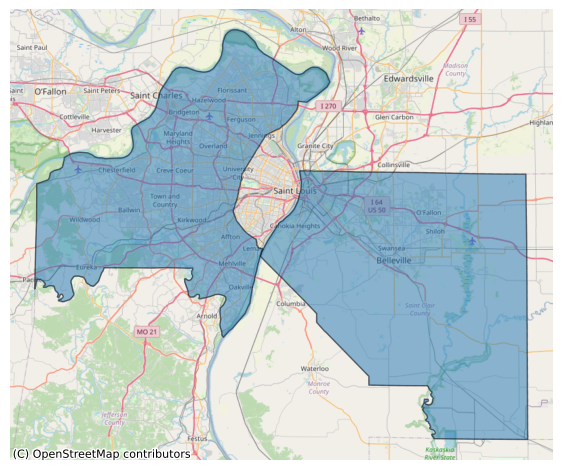

In [ ]:
import geopandas as gpd
import contextily as ctx


gdf_projected = gdf.to_crs(epsg=3857)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Plot your polygons
gdf_projected.plot(ax=ax, alpha=0.5, edgecolor='k')

# Add a basemap (using, for example, Stamen Toner Lite)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for a cleaner look
ax.set_axis_off()

# Save the static map to an image file if desired
plt.savefig('static_map.png', bbox_inches='tight', pad_inches=0)

# Display the map
plt.show()


In [82]:
ctx.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://tile.openstreetmap.de/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'html_attribution': '&copy; OpenStreetMap France | &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) OpenStreetMap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles style by <a href="https://www.hotosm.org/" target="_blank">Humanitarian OpenStreetMap Team</a> hosted by <a href="https://openstreetmap.fr/" target="_blank">OpenStreetMap France</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France',
   'name': 'OpenStreetMap.HOT'},
  'BZH': {'url': 'https://tile.openstreetmap.bzh/br/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="http://www.openstreetmap.bzh/" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'bounds': [[46.2, -5.5], [50, 0.7]],
   'name': 'OpenStreetMap.BZH'},
  'CAT': {'url': 'https://tile.openstreetmap.bzh/ca/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, Tiles courtesy of <a href="https://www.openstreetmap.cat" target="_blank">Breton OpenStreetMap Team</a>',
   'attribution': '(C) OpenStreetMap contributors, Tiles courtesy of Breton OpenStreetMap Team',
   'name': 'OpenStreetMap.CAT'}},
 'MapTilesAPI': {'OSMEnglish': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'en/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMEnglish'},
  'OSMFrancais': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
   'attribution': '(C) MapTiles API, (C) OpenStreetMap contributors',
   'variant': 'fr/map/v1',
   'apikey': '<insert your api key here>',
   'max_zoom': 19,
   'name': 'MapTilesAPI.OSMFrancais'},
  'OSMEspagnol': {'url': 'https://maptiles.p.rapidapi.com/{variant}/{z}/{x}/{y}.png?rapidapi-key={apikey}',
   'html_attribution': '&copy; <a href="http://www.maptilesapi.com/">MapTiles API</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contribut